In [106]:
import os
import pandas as pd
from sklearn.utils import resample
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

In [107]:
base_path = "C:\\Users\\vbaub\\Equinix\\datasets\\LEFL\\"
ex2_path = os.path.join(base_path, 'Ex2 - Data sample.csv')

In [108]:
df = pd.read_csv(ex2_path)
df.head()

,Unnamed: 0,ID,Fold,Target,Var4,Var5,Var6,Var7,Var8,Var9,...,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163
0,1,1,IS,0,40,3,1,5304.570,0,18.609524,...,0,0,0,1,0,0,0,53.04570,1,6
1,2,2,IS,0,26,4,1,884.095,0,25.970874,...,0,0,0,0,0,0,0,884.09500,3,5
2,4,3,IS,0,30,2,1,3536.380,0,25.686275,...,0,0,0,1,0,0,0,88.40950,1,0
3,5,4,IS,0,52,1,1,884.095,0,18.019608,...,0,0,0,0,0,0,0,353.63800,7,2
4,6,5,IS,0,31,2,1,9725.045,0,28.666667,...,0,0,0,0,0,0,0,8.84095,9,3


In [109]:
df.shape

(13015, 164)

In [110]:
df.Target.value_counts()

0    12734
1      281
Name: Target, dtype: int64

In [111]:
data = df[df.Fold == 'IS']
data.Target.value_counts()

0    8043
1     199
Name: Target, dtype: int64

In [112]:
data = data.drop(['Unnamed: 0','ID','Fold'], axis=1)

In [113]:
df_majority = data[data.Target==0]
df_minority = data[data.Target==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=8043,random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [114]:
df_upsampled.shape

(16086, 161)

In [115]:
df_upsampled.Target.value_counts()

1    8043
0    8043
Name: Target, dtype: int64

In [116]:
df_upsampled.columns

Index(['Target', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9', 'Var10',
       'Var11', 'Var12',
       ...
       'Var154', 'Var155', 'Var156', 'Var157', 'Var158', 'Var159', 'Var160',
       'Var161', 'Var162', 'Var163'],
      dtype='object', length=161)

In [117]:
conti_feature = []
for index, val in df_upsampled.dtypes.iteritems():
    if str(val) == 'float64':
        conti_feature.append(index)
print(conti_feature)

['Var7', 'Var9', 'Var13', 'Var14', 'Var24', 'Var25', 'Var44', 'Var72', 'Var73', 'Var81', 'Var82', 'Var83', 'Var85', 'Var95', 'Var129', 'Var130', 'Var131', 'Var136', 'Var161']


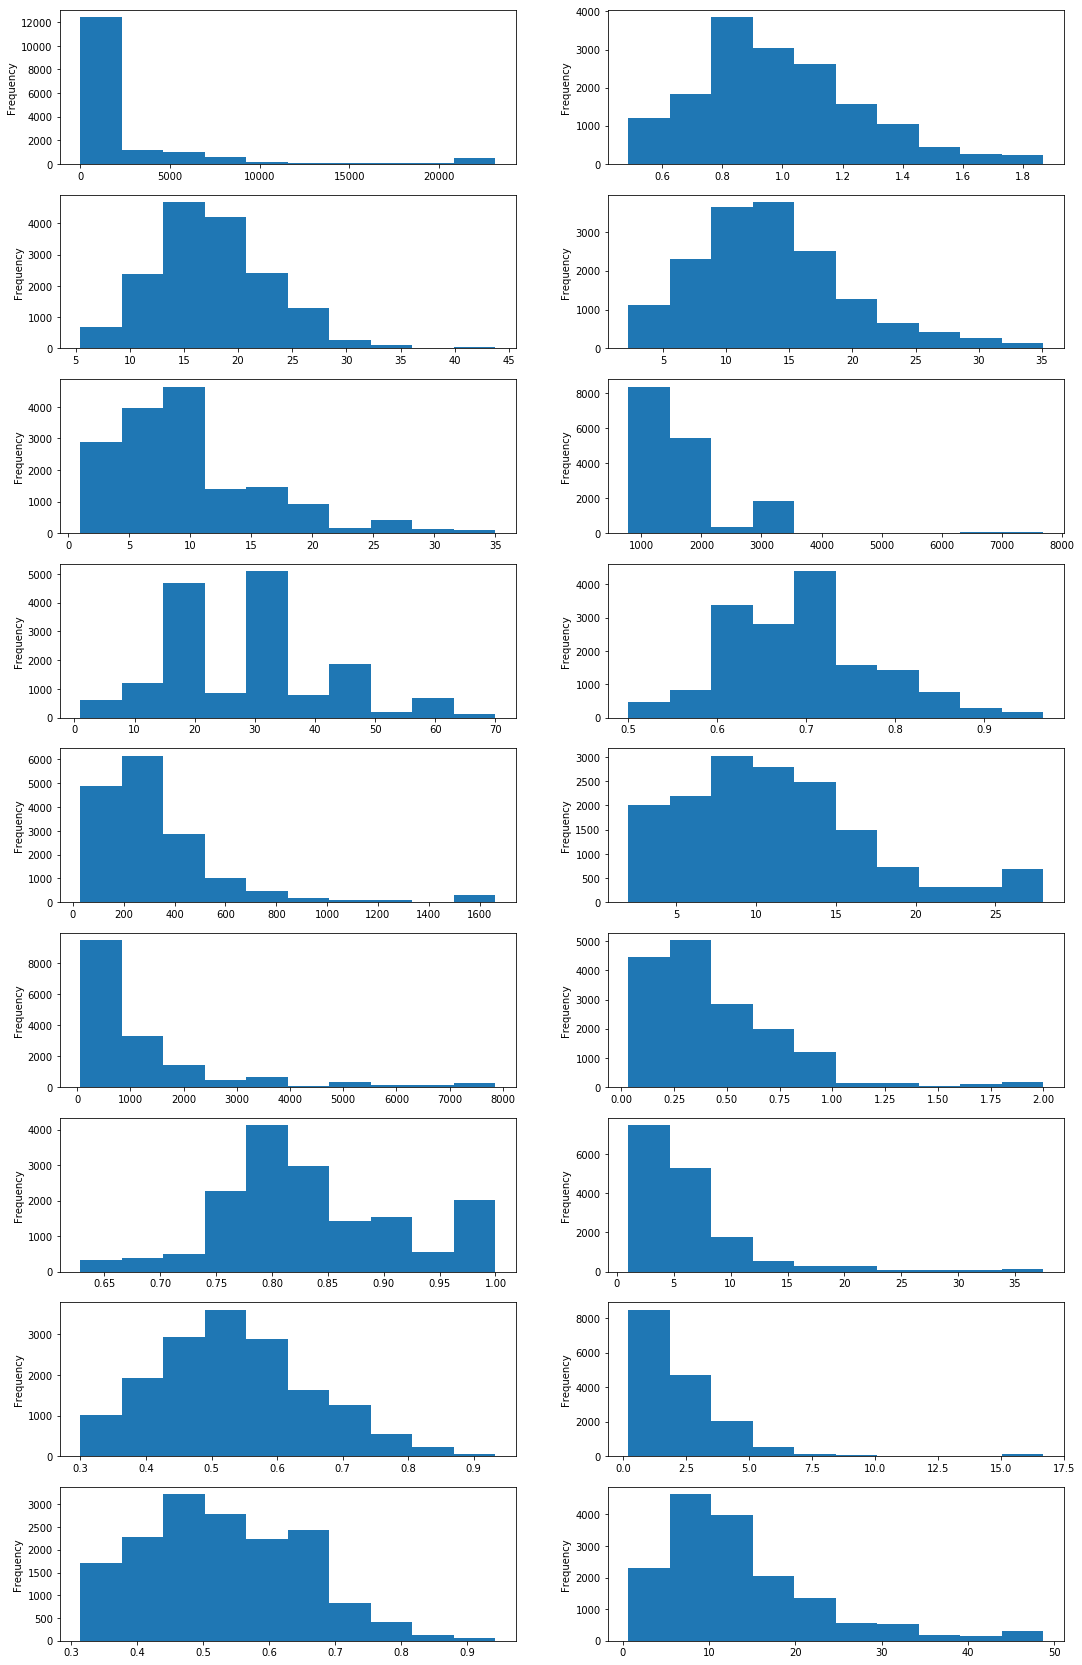

In [118]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=len(conti_feature)//2, ncols=2)
j = len(conti_feature)//2
for i in range(len(conti_feature)//2):
    df_upsampled[conti_feature[i]].plot(ax=axes[i,0] ,kind = 'hist', figsize = (18,30))
    df_upsampled[conti_feature[j]].plot(ax=axes[i,1], kind = 'hist')
    j = j+1

### Observation:

#### 1. Data is not normalized [Normalization is required] 
#### 2. Data is is properly distributed too. [Transformation required]

#### Data Createation:

In [119]:
X = df_upsampled.drop('Target', axis = 1)
y = df_upsampled['Target']

### Solution:
#### Standardization

In [120]:
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df, columns=X.columns)

C:\Users\vbaub\AppData\Local\conda\conda\envs\tpot\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vbaub\AppData\Local\conda\conda\envs\tpot\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Feature selection by regularization

In [124]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(scaled_df, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(scaled_df)
print("Origin Features:", scaled_df.shape[1])
print("Selected Features:", X_new.shape[1])

Origin Features: 160
Selected Features: 138


#### Train test Split:

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 0)

#### Model Selection and hyper perameter tuning by autoML: 

In [30]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_mnist_pipeline_2.py')

Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0
Generation 5 - Current best internal CV score: 1.0

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.1, min_samples_leaf=3, min_samples_split=19, n_estimators=100)
1.0


True

### Model_traning_ testing:

In [126]:
clf_pipeline = ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=19, n_estimators=100)
clf_pipeline.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=19,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [127]:
X_train.shape

(12868, 138)

In [128]:
y_train_pred = clf_pipeline.predict(X_train)
y_test_pred = clf_pipeline.predict(X_test)
print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))

Train Accuracy:  1.0
Test Accuracy:  1.0


In [129]:
y_train.value_counts()

0    6471
1    6397
Name: Target, dtype: int64

In [130]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1572
           1       1.00      1.00      1.00      1646

   micro avg       1.00      1.00      1.00      3218
   macro avg       1.00      1.00      1.00      3218
weighted avg       1.00      1.00      1.00      3218



### Testing on Unseen Data:

In [131]:
data_test_original = df[df.Fold == 'OS']

In [132]:
data_test_original.columns

Index(['Unnamed: 0', 'ID', 'Fold', 'Target', 'Var4', 'Var5', 'Var6', 'Var7',
       'Var8', 'Var9',
       ...
       'Var154', 'Var155', 'Var156', 'Var157', 'Var158', 'Var159', 'Var160',
       'Var161', 'Var162', 'Var163'],
      dtype='object', length=164)

In [133]:
X_test_original = data_test_original.drop(['Unnamed: 0','ID','Fold', 'Target'], axis=1)
y_test_original = data_test_original['Target']
X_test_original.shape

(4773, 160)

In [134]:
scaled_X_test_original = scaler.transform(X_test_original)
X_test_new_original = model.transform(scaled_X_test_original)

C:\Users\vbaub\AppData\Local\conda\conda\envs\tpot\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [135]:
X_test_new_original.shape

(4773, 138)

In [136]:
y_test_original_pred = clf_pipeline.predict(X_test_new_original)

In [139]:
print("Accuracy on unseen train data [ OS ]: ", accuracy_score(y_test_original, y_test_original_pred))

Accuracy on unseen train data [ OS ]:  0.9828200293316572
